In [3]:

# coding: utf-8

import numpy as np
import caffe
import os
import matplotlib.pyplot as plt
%matplotlib inline
# get_ipython().magic(u'matplotlib inline')


# set display defaults
plt.rcParams['figure.figsize'] = (10, 10)        # large images
# don't interpolate: show square pixels
plt.rcParams['image.interpolation'] = 'nearest'
# use grayscale output rather than a (potentially misleading) color heatmap
plt.rcParams['image.cmap'] = 'gray'


caffe.set_mode_cpu()
# caffe.set_device(0)


def vis_square(data):
    """Take an array of shape (n, height, width) or (n, height, width, 3)
       and visualize each (height, width) thing in a grid of size approx. sqrt(n) by sqrt(n)"""
    # normalize data for display
    data = (data - data.min()) / (data.max() - data.min())

    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = (((0, n ** 2 - data.shape[0]),
                (0, 1), (0, 1))                 # add some space between filters
               + ((0, 0),) * (data.ndim - 3))  # don't pad the last dimension (if there is one)
    data = np.pad(data, padding, mode='constant',
                  constant_values=1)  # pad with ones (white)

    # tile the filters into an image
    data = data.reshape(
        (n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape(
        (n * data.shape[1], n * data.shape[3]) + data.shape[4:])

    plt.imshow(data)
    plt.axis('off')


def get_max_xy(data):
    h = data.shape[0]
    w = data.shape[1]
    idx = data.ravel().argmax()
    return idx / w, idx % w


def get_net(model_def, model_weights, display=True):
    model_def = os.path.abspath(model_def)
    model_weights = os.path.abspath(model_weights)

    net = caffe.Net(model_def, model_weights, caffe.TEST)
    net.forward()
    if display:
        for layer_name, blob in net.blobs.iteritems():
            print layer_name + '\t' + str(blob.data.shape)
    return net








def get_feat_by_kernel_spatial_idx(layer_name,
                                   img_idx,
                                   cls_idx,
                                   net,
                                   kernel_spatial_idx,
                                   group_idx=None,
                                   display=True):

    layer = net.layer_dict[layer_name]

    num_classes = layer.blobs[0].data.shape[0]
    assert cls_idx < num_classes,    'cls_idx is out of range,it should be between (0,{:d})'.format(
        num_classes - 1)

    filters_cls = layer.blobs[0].data[cls_idx]
    bias_cls = layer.blobs[1].data[cls_idx]

#     filter param
    kernel_in_channels = filters_cls.shape[0]
    kernel_space_dim = filters_cls.shape[-1] * filters_cls.shape[-2]

#     bottom data param
    bottom_name = net.bottom_names[layer_name][0]
    bottom_shape = net.blobs[bottom_name].data.shape

    batch_size = bottom_shape[0]
    in_channels = bottom_shape[1]
    height = bottom_shape[2]
    width = bottom_shape[3]

    assert img_idx < batch_size,    'img_idx is out of range,it should be between (0,{:d})'.format(
        batch_size - 1)

#     so infer ps_group
    assert in_channels % kernel_in_channels == 0, 'filter shape error'
    ps_group = in_channels / kernel_in_channels


#    check if use all in channels or ps_group channels
    if kernel_space_dim == ps_group:
        ps = True
        group_idx = kernel_spatial_idx
    else:
        ps = False
        assert ps_group == 1, 'just support ps_group=1 now'
        group_idx = 0

    assert group_idx is not None, 'group_idx must be specific in normal model'
    assert group_idx < ps_group,    'group_idx is out of range, it should be between (0,{:d})'.format(
        ps_group - 1)

    conv_g = net.blobs[bottom_name]    .data[img_idx,
                                             kernel_in_channels * group_idx:kernel_in_channels * (group_idx + 1)]

    conv_g_reshaped = conv_g.reshape((kernel_in_channels, -1))
    filters_cls = filters_cls.reshape((kernel_in_channels, -1))
    if ps:
        filters_cls_g = filters_cls[:, group_idx]
    else:
        assert kernel_spatial_idx is not None,        'kernel_spatial_idx must be specific in normal model'
        filters_cls_g = filters_cls[:, kernel_spatial_idx]

    filters_cls_g_reshaped = filters_cls_g.reshape((1, -1))
    conv_cls_g = filters_cls_g_reshaped.dot(conv_g_reshaped) + bias_cls

    conv_cls_g_reshaped = conv_cls_g.reshape((1, height, width))
    if display:
        plt.figure(figsize=(2, 2))
        vis_square(conv_cls_g_reshaped)
    return conv_cls_g_reshaped


def get_all_feat_by_kernel_spatial_idx(layer_name,
                                       img_idx,
                                       cls_idx,
                                       net):
    weight_shape = net.layer_dict[layer_name].blobs[0].data[cls_idx].shape
    kernel_spatial_dim = weight_shape[-1] * weight_shape[-1]
    for kernel_spatial_idx in range(kernel_spatial_dim):
        get_feat_by_kernel_spatial_idx(layer_name, img_idx, cls_idx, net,
                                       kernel_spatial_idx)


def out_map_in(spatial_center, kernel_spatial, pad, stride, dilation=1):
    # param: kernel_spatial is 2D referring to spatial position

    out_h_idx = spatial_center[0]
    out_w_idx = spatial_center[1]
    in_h_idx = out_h_idx * stride - pad + kernel_spatial[0] * dilation
    in_w_idx = out_w_idx * stride - pad + kernel_spatial[1] * dilation
    return in_h_idx, in_w_idx


def get_next_layer_activated_points(net,
                                    layer_name,
                                    center,
                                    image_idx,
                                    pad=0,
                                    stride=1,
                                    dilation=2, ps=True):

    # arg: center is 3D like (c,h,w)
    layer = net.layer_dict[layer_name]
    bottom_name = net.bottom_names[layer_name][0]
#     shape: (c,h,w)
    data = net.blobs[bottom_name].data[image_idx]
    in_c = data.shape[0]
    in_h = data.shape[1]
    in_w = data.shape[2]
#     params
    weights = layer.blobs[0].data
#     print weights.shape
    bias = layer.blobs[1].data
#     print weights.shape
    h = weights.shape[-2]
    w = weights.shape[-1]
    kernel_spatial_dim = h * w
#     print kernel_spatial_dim
    out_c_idx = center[0]
    out_h_idx = center[1]
    out_w_idx = center[2]

    weights_sliced = weights[out_c_idx]
    res = []
    for kernel_spatial_idx in range(kernel_spatial_dim):
        max_activate_position = []
        if ps:
            assert in_c % kernel_spatial_dim == 0, 'input channel is not correct'
            in_c_per_g = in_c / kernel_spatial_dim
            data_sliced = data[in_c_per_g *
                               kernel_spatial_idx:in_c_per_g * (kernel_spatial_idx + 1)]
        else:
            data_sliced = data
        kernel_spatial = (kernel_spatial_idx / w, kernel_spatial_idx % w)

        in_spatial = out_map_in(center[1:],
                                kernel_spatial,
                                pad,
                                stride,
                                dilation)

        scores = weights_sliced[:, kernel_spatial_idx / w, kernel_spatial_idx %
                                w] * data_sliced[:, in_spatial[0], in_spatial[1]]
        in_c_idx = scores.argmax()
        if ps:
            in_c_idx = in_c_per_g * kernel_spatial_idx + in_c_idx
        max_activate_position.append(in_c_idx)
        max_activate_position += list(in_spatial)
        res.append(max_activate_position)
    return res


# In[462]:


def feat_map_raw(activated_points, feat_map_size, origial_map_size):
    scale = np.array(origial_map_size).astype(
        np.float) / np.array(feat_map_size)
    return np.array(activated_points)[:, 1:] * scale


def vis_activated_point(net, activated_points, pixel_val=0.5):
    #     note that activated points is 2D (h,w)
    data = net.blobs['data'].data[0].copy()
    activated_points = list(activated_points)
    for origial_activated_point in activated_points:
        #         print np.ceil(origial_activated_point[0])
        data[:, np.ceil(origial_activated_point[0]).astype(np.int),
             np.ceil(origial_activated_point[1]).astype(np.int)]\
            = pixel_val
    vis_square(data)


def normalize(all_scores, type='relu'):
    _sum = 0
    all_proportion = []
    for idx, score in enumerate(all_scores):
        if score < 0 and type == 'relu':
            all_scores[idx] = 0
            continue
        _sum += score
    for score in all_scores:
        all_proportion.append(1.0 * score / _sum)
    return all_proportion


def get_part_proportion(layer_name,
                        next_activated_points,
                        net,
                        image_idx,
                        cls_idx,
                        ps=True):
    all_scores = []
    layer = net.layer_dict[layer_name]
#     params
    weights = layer.blobs[0].data
    h = weights.shape[-2]
    w = weights.shape[-1]
    kernel_spatial_dim = h * w
    for kernel_spatial_idx in range(kernel_spatial_dim):
        if ps:
            group_idx = kernel_spatial_idx
        else:
            group_idx = 0
        conv_cls_g_reshaped = get_feat_by_kernel_spatial_idx(layer_name,
                                                             image_idx,
                                                             cls_idx,
                                                             net,
                                                             kernel_spatial_idx,
                                                             group_idx,
                                                             False)
        next_activated_point = next_activated_points[kernel_spatial_idx]
        all_scores.append(
            conv_cls_g_reshaped[0, next_activated_point[-2], next_activated_point[-1]])
    return normalize(all_scores), all_scores


def help_vis_max_activated_point(net, layer_name, next_activated_points):
    #     next_activated_points = get_next_layer_max_xy(net,'conv5',center,0)
    feat_map_size = net.blobs[layer_name].data.shape[2:]
    origial_map_size = net.blobs['data'].data.shape[2:]
    origial_activated_points = feat_map_raw(next_activated_points,
                                            feat_map_size,
                                            origial_map_size)
    vis_activated_point(net, origial_activated_points)


# test_net4()


In [1]:
def test_net3():
    model_def = './PSConv_lenet_train_test.prototxt'
    model_weights = 'PSConv/PSConv_lenet__iter_20000.caffemodel'

    net3 = get_net(model_def, model_weights)

    # first image to test
    img_idx = 0
    # first label corresponding to the image
    cls_idx = 7
    # the last conv layer
    layer_name = 'conv5'
    
    print 'separate feature visualization'
    get_all_feat_by_kernel_spatial_idx(layer_name,
                                       img_idx,
                                       cls_idx,
                                       net3)
    cls_idx = 7
    center = []
    center.append(cls_idx)
    center += list(
        get_max_xy(net3.blobs[layer_name].data[img_idx, cls_idx]))

    # print center
    next_activated_points = get_next_layer_activated_points(net3,
                                                            layer_name,
                                                            center,
                                                            0)
    # print next_activated_points
#     feat_map_size = net3.blobs['conv4'].data.shape[2:]
#     origial_map_size = net3.blobs['data'].data.shape[2:]
#     origial_activated_points = feat_map_raw(next_activated_points,
#                                             feat_map_size,
#                                             origial_map_size)

#     vis_activated_point(net3, origial_activated_points)
    
    help_vis_max_activated_point(net3,
                                 layer_name, 
                                 next_activated_points)
    pad = 0
    stride = 2
    dilation = 1
#     for next_activated_point in next_activated_points:
#         print get_next_layer_activated_points(net3, 'conv4', next_activated_point, 0, pad, stride, dilation)

#     print next_activated_points

    get_all_feat_by_kernel_spatial_idx('conv5', 0, 7, net3)

    all_proportion, all_scores = get_part_proportion('conv5',
                                                     next_activated_points,
                                                     net3,
                                                     img_idx,
                                                     cls_idx,
                                                     ps=True)
    print all_proportion
    print sum(all_scores)

#     net3.blobs['conv5'].data[0, 7]

#     get_all_feat_by_kernel_spatial_idx('conv4', 0, 79, net3)

#     get_all_feat_by_kernel_spatial_idx('conv4', 0, 128, net3)

#     get_all_feat_by_kernel_spatial_idx('conv4', 0, 262, net3)

#     print center

In [ ]:
test_net3()

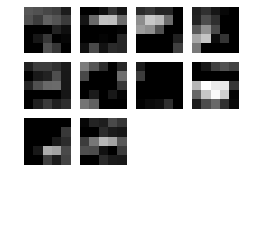

In [10]:
vis_square(net3.blobs['conv5'].data[0,:])

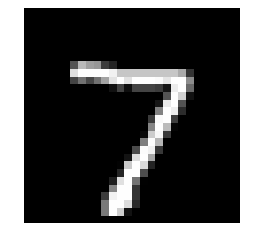

In [6]:
vis_square(net3.blobs['data'].data[0])

In [ ]:
def test_net4():
    model_def = '../Conv_lenet_train_test.prototxt'
    model_weights = '../temp/Conv_lenet_8_iter_20000.caffemodel'
    net4 = get_net(model_def, model_weights)
    layer_name = 'conv5'
    img_idx = 0

    vis_square(net4.blobs['conv5'].data[img_idx, :])
    get_all_feat_by_kernel_spatial_idx('conv5', 0, 7, net4)

    cls_idx = 7
    center = []
    center.append(cls_idx)
    center += list(get_max_xy(net4.blobs[layer_name].data[0, 7]))
    print center
    next_activated_points = get_next_layer_activated_points(net4,
                                                            layer_name,
                                                            center,
                                                            img_idx,
                                                            ps=False)
    print next_activated_points
    all_proportion, all_scores = get_part_proportion(layer_name,
                                                     next_activated_points,
                                                     net4,
                                                     img_idx,
                                                     cls_idx,
                                                     ps=False)
    print all_proportion
    print sum(all_scores)
    print net4.blobs['conv5'].data[0, 7]
    vis_square(net4.blobs['conv5'].data[0])

    help_vis_max_activated_point(net4, 'conv4', next_activated_points)

In [18]:
def test_net4_v1():
    model_def = 'Conv_lenet_train_test.prototxt'
    model_weights = 'Conv/Conv_lenet__iter_20000.caffemodel'

    net4 = get_net(model_def, model_weights)
    cls_idx = 7
    layer_name = 'conv5'
    center = []
    center.append(cls_idx)
    center+=list(get_max_xy(net4.blobs['conv5'].data[0,7]))
    # print center
    next_activated_points = get_next_layer_activated_points(net4,'conv5',center,0)
    # print next_activated_points
    help_vis_max_activated_point(net4, layer_name, next_activated_points)

In [ ]:
test_net4_v1()